Add the path.

In [1]:
import sys

sys.path.append("C:/Users/A.C.EA/Documents/Fylix Internship 2023 - 2024/CQM-TSP/")

## Quantum Implementation of Travelling Salesman Problem : Optimizing QCBO (Constrained QUBO) using Quantum Annealing

### Getting Started

This notebook is dedicated to a QUBO implementation of the Travelling Salesman Problem (TSP) using D-Wave's Ocean suite package. The model is implemented as a Constrained Quadratic Model (CQM). The overall implementation is in three parts :

1)  Decision variables : Define the binary variables for visiting the nodes (i.e. $X$<sub>12</sub> = 1 means going from node 1 to node 2). For N nodes, there will be $N$ x $N-1$ binary variables.

2)  Objective function : Define the objective (minimize the overall distance $\sum_{i=1}^{N}$ $\sum_{j!=i, j=1}^{N}$ $X$<sub>ij</sub> $C$<sub>ij</sub> where $C$<sub>ij</sub> is the distance from i to j ($C$<sub>ij</sub> is not necessarily equal to $C$<sub>ji</sub> as in real world problems, the distances are non-euclidean and depend on roads))

3)  Constraints : Define the constraints 
    - (Only enter each node once and exit from each node once (visit each node once) $\sum_{i=1, i!=j}^{N}$ $X$<sub>ij</sub> = 1 for $j = 1, ... , N$ and $\sum_{j=1, j!=i}^{N}$ $X$<sub>ij</sub> = 1 for $i = 1, ... , N$.
    - Furthermore, we must have ONE route visiting all nodes and coming back, also known as a Hamiltonian cycle, and we model this using the Dantzig–Fulkerson–Johnson (DFJ) formulation of Subtour Elimintation Constraint as $\sum_{i\in Q}^{N}$ $\sum_{j!=i, j\in Q}^{N}$ $X$<sub>ij</sub> $\le |Q|-1$ for $∀Q \subseteq ${1, ..., N}$, |Q| \ge 2$

<p style="text-align:center;"><img src="tsp.png" alt="TSP"></p>
<p style="text-align:center;"> Figure 1 : Travelling the USA using TSP </p>

In [2]:
import os

from dimod.serialization.format import Formatter

from collections.abc import Iterable
import re
os.chdir('..')

import dwave
from dimod import ConstrainedQuadraticModel, Binary, quicksum
import numpy as np
import itertools
from matplotlib import pyplot as plt

print("All packages imported successfully!")

All packages imported successfully!


We will implement some helper functions for finding the Q list which is a list of all subsets of {1, ... , N}, and findining the distance between nodes if no distance matrix is defined beforehand.

- containsNumber(value) : A helper function for extracting the numbers from a string for plotting purposes, for instance if $X$<sub>12</sub> is equal to 1, we would like to extract the sequence [1,2] from the variable. The parameter is a string, i.e. "$X$<sub>12</sub>".

- findsubsets(s, n) : A helper function for generating the subsets of a list s given a fixed size n.

- find_all_subsets(s) : A helper function for generating all subsets of a list s using findsubsets function.

- distance_between_points : A helper function for calculating the Euclidean distance between two points in a two-dimensional space.

In [21]:
def containsNumber(value: str) -> Iterable[int]:
    """ Checks if value contains a number and
    returns a list of numbers in the value.

    Parameters
    ----------
    `value` (str):
        The string to check.

    Returns
    -------
    `num_list` (Iterable[int]):
        The list of numbers in the value.
    """
    # Find the numbers from the string
    return [(int(num)-1) for num in re.findall(r'\d+', value)]

# Function to generate the subsets of a list given size
def find_subsets(s: int,
                 n: int) -> Iterable[Iterable[int]]:
    """ Return the list of all subsets of length n in s.

    Parameters
    ----------
    `s` (int):
        The number of nodes.
    `n` (int):
        The length of the subsets.

    Returns
    -------
    `subsets` (Iterable[Iterable[int]]):
        The list of all subsets of length n in s.
    """
    return list(itertools.combinations(s, n))

# Function to generate all the subsets of a list
def find_all_subsets(s: Iterable[Iterable[int]]):
    """ Function to generate the subtours for the given graph.

    Returns
    -------
    `subtours` : Iterable[Iterable[int]]
        The subtours.
    """
    subtours = []
    for i in range(2, len(s)):
        subtours.extend(find_subsets(s, i))
    return subtours

# Function for calculating the euclidean distance
def distance_between_points(point_A: Iterable[int],
                            point_B: Iterable[int]):
    """ Function for calculating the euclidean distance.

    Parameters
    ----------
    `point_A` (Iterable[int]):
        The first point.
    `point_B` (Iterable[int]):
        The second point.

    Returns
    -------
    `distance` (float):
        The euclidean distance between the two points.
    """
    return np.sqrt((point_A[0] - point_B[0]) ** 2 + (point_A[1] - point_B[1]) ** 2)

We will initialize a CQM instance for creating the QCBO model.

In [4]:
# Initializing the CQM
cqm = ConstrainedQuadraticModel()

We will initialize the objective for the QCBO model.

In [5]:
# Initializing the objective
objective = 0

We will initialize the constraints for the QCBO model. There will be three constraints :

- Only enter each node once
- Only exit from each node once
- Visit all nodes

In [6]:
# Initializing the constraints
constraint_1 = 0
constraint_2 = 0
constraint_3 = 0

We will define the list of nodes' coordinates (this step is not necessary if you already have the distance matrix).

In [7]:
# List of coordinates
coordinates = np.array([[1, 1], [2, 3], [3, 2], [2, 4], [1, 5], [3, 6]])   # 6 nodes

x_vals = coordinates[:, 0]
y_vals = coordinates[:, 1]

We will generate the list of all node indices for generating the subsets.

In [8]:
# Number of nodes
n = len(coordinates)
global_set = [i for i in range(n)]

In [9]:
# List of subtours
subtours = find_all_subsets(global_set)
print(subtours)

# Number of subsets
S = len(subtours)
print(S)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 3, 4), (0, 3, 5), (0, 4, 5), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 3, 4), (1, 3, 5), (1, 4, 5), (2, 3, 4), (2, 3, 5), (2, 4, 5), (3, 4, 5), (0, 1, 2, 3), (0, 1, 2, 4), (0, 1, 2, 5), (0, 1, 3, 4), (0, 1, 3, 5), (0, 1, 4, 5), (0, 2, 3, 4), (0, 2, 3, 5), (0, 2, 4, 5), (0, 3, 4, 5), (1, 2, 3, 4), (1, 2, 3, 5), (1, 2, 4, 5), (1, 3, 4, 5), (2, 3, 4, 5), (0, 1, 2, 3, 4), (0, 1, 2, 3, 5), (0, 1, 2, 4, 5), (0, 1, 3, 4, 5), (0, 2, 3, 4, 5), (1, 2, 3, 4, 5)]
56


We will generate the distance matrix from the list of coordinates using a helper function (in this example we are using a Euclidean distance calculator).

In [10]:
# Initialize the distance matrix
distance_matrix = []

# Calculate the distance matrix
for a in coordinates:
    distance_matrix.append([distance_between_points(a, b) for b in coordinates])

# Return the distance matrix
print(distance_matrix)

[[0.0, 2.23606797749979, 2.23606797749979, 3.1622776601683795, 4.0, 5.385164807134504], [2.23606797749979, 0.0, 1.4142135623730951, 1.0, 2.23606797749979, 3.1622776601683795], [2.23606797749979, 1.4142135623730951, 0.0, 2.23606797749979, 3.605551275463989, 4.0], [3.1622776601683795, 1.0, 2.23606797749979, 0.0, 1.4142135623730951, 2.23606797749979], [4.0, 2.23606797749979, 3.605551275463989, 1.4142135623730951, 0.0, 2.23606797749979], [5.385164807134504, 3.1622776601683795, 4.0, 2.23606797749979, 2.23606797749979, 0.0]]


We can alternatively use a pre-made distance matrix and skip the step above.

In [10]:
# Example distance matrix for 17 nodes
distance_matrix = [[0, 633, 257,  91, 412, 150,  80, 134, 259, 505, 353, 324,  70, 211, 268, 246, 121],
                 [633, 0, 390, 661, 227, 488, 572, 530, 555, 289, 282, 638, 567, 466, 420, 745, 518],
                 [257, 390,   0, 228, 169, 112, 196, 154, 372, 262, 110, 437, 191,  74,  53, 472, 142],
                  [91, 661, 228,   0, 383, 120,  77, 105, 175, 476, 324, 240,  27, 182, 239, 237,  84],
                 [412, 227, 169, 383,   0, 267, 351, 309, 338, 196,  61, 421, 346, 243, 199, 528, 297],
                 [150, 488, 112, 120, 267,   0,  63,  34, 264, 360, 208, 329,  83, 105, 123, 364,  35],
                  [80, 572, 196,  77, 351,  63,   0,  29, 232, 444, 292, 297,  47, 150, 207, 332,  29],
                 [134, 530, 154, 105, 309,  34,  29,   0, 249, 402, 250, 314,  68, 108, 165, 349,  36],
                 [259, 555, 372, 175, 338, 264, 232, 249,   0, 495, 352,  95, 189, 326, 383, 202, 236],
                 [505, 289, 262, 476, 196, 360, 444, 402, 495,   0, 154, 578, 439, 336, 240, 685, 390],
                 [353, 282, 110, 324,  61, 208, 292, 250, 352, 154,   0, 435, 287, 184, 140, 542, 238],
                 [324, 638, 437, 240, 421, 329, 297, 314,  95, 578, 435,   0, 254, 391, 448, 157, 301],
                  [70, 567, 191,  27, 346,  83,  47,  68, 189, 439, 287, 254,   0, 145, 202, 289,  55],
                 [211, 466,  74, 182, 243, 105, 150, 108, 326, 336, 184, 391, 145,   0,  57, 426, 96],
                 [268, 420,  53, 239, 199, 123, 207, 165, 383, 240, 140, 448, 202,  57,   0, 483, 153],
                 [246, 745, 472, 237, 528, 364, 332, 349, 202, 685, 542, 157, 289, 426, 483,  0, 336],
                 [121, 518, 142,  84, 297,  35,  29,  36, 236, 390, 238, 301,  55,  96, 153, 336,  0]]

In [11]:
# Example distance matrix for 15 nodes
distance_matrix = [[0, 29, 82, 46, 68, 52, 72, 42, 51, 55, 29, 74, 23, 72, 46],
                   [29, 0, 55, 46, 42, 43, 43, 23, 23, 31, 41, 51, 11, 52, 21],
                   [82, 55, 0, 68, 46, 55, 23, 43, 41, 29, 79, 21, 64, 31, 51],
                   [46, 46, 68, 0, 82, 15, 72, 31, 62, 42, 21, 51, 51, 43, 64],
                   [68, 42, 46, 82, 0, 74, 23, 52, 21, 46, 82, 58, 46, 65, 23],
                   [52, 43, 55, 15, 74, 0, 61, 23, 55, 31, 33, 37, 51, 29, 59],
                   [72, 43, 23, 72, 23, 61, 0, 42, 23, 31, 77, 37, 51, 46, 33],
                   [42, 23, 43, 31, 52, 23, 42, 0, 33, 15, 37, 33, 33, 31, 37],
                   [51, 23, 41, 62, 21, 55, 23, 33, 0, 29, 62, 46, 29, 51, 11],
                   [55, 31, 29, 42, 46, 31, 31, 15, 29, 0, 51, 21, 41, 23, 37],
                   [29, 41, 79, 21, 82, 33, 77, 37, 62, 51, 0, 65, 42, 59, 61],
                   [74, 51, 21, 51, 58, 37, 37, 33, 46, 21, 65, 0, 61, 11, 55],
                   [23, 11, 64, 51, 46, 51, 51, 33, 29, 41, 42, 61, 0, 62, 23],
                   [72, 52, 31, 43, 65, 29, 46, 31, 51, 23, 59, 11, 62, 0, 59],
                   [46, 21, 51, 64, 23, 59, 33, 37, 11, 37, 61, 55, 23, 59, 0]]

We will define the binary variables and add them to our objective function alongside their costs based on the distance matrix.

In [11]:
# Initializing the decision var
X_ = []

# Objective
for i in range(n):
    for j in range(n):
        if i == j:
            X_.append(0)
        else:
            X_.append(Binary('X_' + str(i + 1) + "_" + str(j + 1)))
    objective += quicksum(distance_matrix[j][i] * X_[j] for j in range(n))
    cqm.set_objective(objective)
    X_.clear()

In [12]:
# Assignment Constraints (Only one entry and exit per node)
for i in range(n):
    for j in range(n):
        if i == j:
            X_.append(0)
        else:
            X_.append(Binary('X_' + str(i + 1) + "_" + str(j + 1)))
    constraint_1 = quicksum(X_[j] for j in range(n))
    cqm.add_constraint(constraint_1 == 1, label="Constraint 1-" + str(i + 1))
    X_.clear()

In [13]:
for j in range(n):
    for i in range(n):
        if i == j:
            X_.append(0)
        else:
            X_.append(Binary('X_' + str(i + 1) + "_" + str(j + 1)))
    constraint_2 = quicksum(X_[i] for i in range(n))
    cqm.add_constraint(constraint_2 == 1, label="Constraint 2-" + str(j + 1))
    X_.clear()

In [14]:
# subtour elimination constraint
for s in range(S):  # s = {1,2}, length of s = 1, so 1 iterations of below
    for i in (subtours[s]):  # len of subtour = 2, so 2 iterations
        for j in (subtours[s]):  # len of subtour = 2 so 2 iterations
            # possible X_ : X1,1 X1,2 X2,1 X2,2
            if i == j:
                continue  # X1,1 and X2,2 are not accepted
            else:
                X_.append(Binary('X_' + str(i + 1) + "_" + str(j + 1)))
    constraint_3 = quicksum(X_[j] for j in range(len(X_)))
    cqm.add_constraint(constraint_3 <= len(subtours[s]) - 1, label="Constraint 3-" + str(s + 1))
    X_.clear()

In [15]:
from cqm import CQMBackend


# Define token
token = 'DEV-6dad5ce3bb8bba232cc09ef8c515e6563a2fe14e'

# Running the sampler to get the sample set
cqm_sampler = CQMBackend(token=token, time=30, label='CQM-TSP')
sampleset = cqm_sampler(problem=cqm)

In [16]:
# Printing the sample set
for c, cval in cqm.constraints.items():
    print(c, cval)
    
feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)

sample = feasible_sampleset.first.sample
Formatter(width=1000).fprint(feasible_sampleset)

Constraint 1-1 X_1_2 + X_1_3 + X_1_4 + X_1_5 + X_1_6 == 1.0
Constraint 1-2 X_2_1 + X_2_3 + X_2_4 + X_2_5 + X_2_6 == 1.0
Constraint 1-3 X_3_1 + X_3_2 + X_3_4 + X_3_5 + X_3_6 == 1.0
Constraint 1-4 X_4_1 + X_4_2 + X_4_3 + X_4_5 + X_4_6 == 1.0
Constraint 1-5 X_5_1 + X_5_2 + X_5_3 + X_5_4 + X_5_6 == 1.0
Constraint 1-6 X_6_1 + X_6_2 + X_6_3 + X_6_4 + X_6_5 == 1.0
Constraint 2-1 X_2_1 + X_3_1 + X_4_1 + X_5_1 + X_6_1 == 1.0
Constraint 2-2 X_1_2 + X_3_2 + X_4_2 + X_5_2 + X_6_2 == 1.0
Constraint 2-3 X_1_3 + X_2_3 + X_4_3 + X_5_3 + X_6_3 == 1.0
Constraint 2-4 X_1_4 + X_2_4 + X_3_4 + X_5_4 + X_6_4 == 1.0
Constraint 2-5 X_1_5 + X_2_5 + X_3_5 + X_4_5 + X_6_5 == 1.0
Constraint 2-6 X_1_6 + X_2_6 + X_3_6 + X_4_6 + X_5_6 == 1.0
Constraint 3-1 X_1_2 + X_2_1 <= 1.0
Constraint 3-2 X_1_3 + X_3_1 <= 1.0
Constraint 3-3 X_1_4 + X_4_1 <= 1.0
Constraint 3-4 X_1_5 + X_5_1 <= 1.0
Constraint 3-5 X_1_6 + X_6_1 <= 1.0
Constraint 3-6 X_2_3 + X_3_2 <= 1.0
Constraint 3-7 X_2_4 + X_4_2 <= 1.0
Constraint 3-8 X_2_5 + X_5_2

In [17]:
for constraint in cqm.iter_constraint_data(sample):
    print(constraint.label, constraint.violation)

Constraint 1-1 0.0
Constraint 1-2 0.0
Constraint 1-3 0.0
Constraint 1-4 0.0
Constraint 1-5 0.0
Constraint 1-6 0.0
Constraint 2-1 0.0
Constraint 2-2 0.0
Constraint 2-3 0.0
Constraint 2-4 0.0
Constraint 2-5 0.0
Constraint 2-6 0.0
Constraint 3-1 -1.0
Constraint 3-2 0.0
Constraint 3-3 -1.0
Constraint 3-4 0.0
Constraint 3-5 -1.0
Constraint 3-6 0.0
Constraint 3-7 0.0
Constraint 3-8 -1.0
Constraint 3-9 -1.0
Constraint 3-10 -1.0
Constraint 3-11 -1.0
Constraint 3-12 -1.0
Constraint 3-13 -1.0
Constraint 3-14 0.0
Constraint 3-15 0.0
Constraint 3-16 0.0
Constraint 3-17 -1.0
Constraint 3-18 -1.0
Constraint 3-19 -2.0
Constraint 3-20 -1.0
Constraint 3-21 0.0
Constraint 3-22 -1.0
Constraint 3-23 -1.0
Constraint 3-24 -1.0
Constraint 3-25 0.0
Constraint 3-26 0.0
Constraint 3-27 -1.0
Constraint 3-28 -1.0
Constraint 3-29 -1.0
Constraint 3-30 0.0
Constraint 3-31 -1.0
Constraint 3-32 -2.0
Constraint 3-33 -1.0
Constraint 3-34 -1.0
Constraint 3-35 0.0
Constraint 3-36 0.0
Constraint 3-37 0.0
Constraint 3-38 -1

In [18]:
for c, v in cqm.constraints.items():
    print('lhs : ' + str(v.lhs.energy(sample)))
    print('rhs : ' + str(v.rhs))
    print('sense  : ' + str(v.sense))
    print("---")

lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense

In [22]:
sample_keys = sample.keys()
sample_solutions = []
for key in sample_keys:
    if sample.get(key) == 1:
        sample_solutions.append(key)
print(sample_solutions)

['X_1_5', 'X_2_3', 'X_3_1', 'X_4_2', 'X_5_6', 'X_6_4']


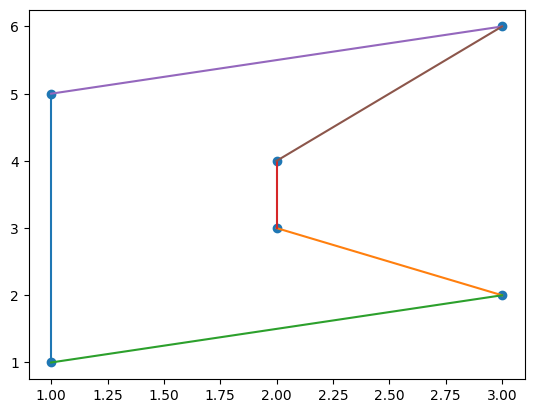

In [23]:
sample_coordinate_sequence = []
for i in range(len(sample_solutions)):
    res = containsNumber(sample_solutions[i])
    sample_coordinate_sequence.append(res)

plt.scatter(x_vals, y_vals)

for i in sample_coordinate_sequence:
    start = coordinates[i[0]]
    end = coordinates[i[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]])

plt.show()

### Constructing the QTSP solver class

Now, we will package this into a `QTSP` class. Before we do so, we will create a base `CQM` class, and a `Graph` class.

The `CQM` base class is the template for creating CQM solver classes.

In [24]:
# Copyright 2023-2024 Amir Ali Malekani Nezhad.
#
# Licensed under the License, Version 1.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://github.com/ACE07-Sev/CQM-TSP/blob/main/LICENSE
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from __future__ import annotations

__all__ = ['CQM']

from abc import ABC, abstractmethod
import os
os.chdir('..')

import dimod


class CQM(ABC):
    """ `CQM` is the base class for implementing constrained quadratic models.
    """
    def __init__(self,
                 time: int,
                 log: bool = True) -> None:
        """ Initializes a `CQM` instance.

        Parameters
        ----------
        `time` (int):
            The time limit for the problem.
        `log` (bool):
            Whether to log the output or not.
        """
        self.time_limit = time
        self.log = log
        # Construct the CQM
        self.cqm = self.define_CQM()

    @abstractmethod
    def define_CQM(self) -> dimod.ConstrainedQuadraticModel:
        """ Function to define the CQM for the given graph.

        Returns
        -------
        `cqm` : dimod.ConstrainedQuadraticModel
            The CQM.
        """
        pass

    @abstractmethod
    def __call__(self) -> None:
        """ Solves the TSP CQM.
        """
        pass

The `Graph` class provides a seamless interface to create and manipulate graphs.

In [31]:
# Copyright 2023-2024 Amir Ali Malekani Nezhad.
#
# Licensed under the License, Version 1.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://github.com/ACE07-Sev/CQM-TSP/blob/main/LICENSE
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from __future__ import annotations

__all__ = ['Graph']

from abc import ABC
from collections.abc import Iterable
import os
os.chdir('..')

import numpy as np
import itertools
from matplotlib import pyplot as plt


class Graph(ABC):
    """ `CQM.Graph` class represents graph data, such as maps whcih
        are used in the TSP.
    """
    def __init__(self,
                 coordinates: Iterable[Iterable[float]],
                 edges: Iterable[Iterable[int]] | None = None) -> None:
        """ 
        Initializes a graph model.

        Parameters
        ----------
        `coordinates` (Iterable[Iterable[float]]):
            The coordinates of the nodes of the graph.
        `edges` (Iterable[Iterable[int]]):
            The edges of the graph.
        """
        self.coordinates = coordinates
        self.num_nodes = len(coordinates)
        self.edges = edges

    def calculate_distance_matrix(self) -> Iterable[Iterable[float]]:
        """ Defines the distance matrix for the given coordinates.

        Returns
        -------
        `Distance_matrix` (Iterable[Iterable[float]]):
            The distance matrix.
        """
        # Initialize the distance matrix
        distance_matrix = []

        def distance_between_points(point_A: Iterable[int],
                                    point_B: Iterable[int]) -> float:
            """ Function for calculating the euclidean distance.

            Parameters
            ----------
            `point_A` (Iterable[int]):
                The first point.
            `point_B` (Iterable[int]):
                The second point.

            Returns
            -------
            `distance` (float):
                The euclidean distance between the two points.
            """
            return np.sqrt((point_A[0] - point_B[0]) ** 2 + (point_A[1] - point_B[1]) ** 2)

        # Calculate the distance matrix
        for a in self.coordinates:
            distance_matrix.append([distance_between_points(a, b) for b in self.coordinates])

        # Return the distance matrix
        return distance_matrix

    def generate_subtours(self) -> Iterable[Iterable[int]]:
        """ Function to generate the subtours for the given graph.

        Returns
        -------
        `subtours` : Iterable[Iterable[int]]
            The subtours.
        """
        # Initialize subtours list
        subtours = []

        def find_subsets(s: int,
                         n: int) -> Iterable[Iterable[int]]:
            """ Return the list of all subsets of length n in s.

            Parameters
            ----------
            `s` (int):
                The number of nodes.
            `n` (int):
                The length of the subsets.

            Returns
            -------
            `subsets` (Iterable[Iterable[int]]):
                The list of all subsets of length n in s.
            """
            return list(itertools.combinations(s, n))

        # Generate subtours
        for i in range(2, self.num_nodes):
            subtours.extend(find_subsets(range(self.num_nodes), i))

        # Return the subtours
        return subtours

    def set_edges(self,
                  edges: Iterable[Iterable[int]]) -> None:
        """ Sets the edges of the graph.

        Parameters
        ----------
        `edges` (Iterable[Iterable[int]]):
            The edges of the graph.
        """
        self.edges = edges

    def plot(self) -> None:
        """ Plots the graph.
        """
        # Plot the graph
        plt.figure(figsize=(10, 10))
        plt.scatter([i[0] for i in self.coordinates], [i[1] for i in self.coordinates], color='red')
        for i in self.edges:
            plt.plot([self.coordinates[i[0]][0], self.coordinates[i[1]][0]],
                     [self.coordinates[i[0]][1], self.coordinates[i[1]][1]], color='blue')
        plt.show()

Using these two classes, we can package the solver.

In [34]:
from __future__ import annotations

__all__ = ['QTSP']

from collections.abc import Iterable
import re
import os
os.chdir('..')

import dimod
from dimod.serialization.format import Formatter
from dimod import ConstrainedQuadraticModel, Binary, quicksum

from cqm.data import Graph
from cqm.solver import CQM
from cqm.backend import CQMBackend


class QTSP(CQM):
    """ `QTSP` is a class for implementing a CQM for the Travelling Salesman Problem.
    """
    def __init__(self,
                 coordinates: Iterable[Iterable[float]],
                 time: int,
                 log: bool = True) -> None:
        """ Initializes a `QTSP` instance.

        Parameters
        ----------
        `coordinates` (Iterable[Iterable[float]]):
            The coordinates of the nodes of the graph.
        `time` (int):
            The time limit for the problem.
        `log` (bool):
            Whether to log the output or not.
        """
        self.graph = Graph(coordinates=coordinates)
        self.time_limit = time
        self.log = log
        # Construct the CQM
        self.cqm = self.define_CQM()

    def define_CQM(self) -> dimod.ConstrainedQuadraticModel:
        """ Function to define the CQM for the given graph.

        Returns
        -------
        `cqm` : dimod.ConstrainedQuadraticModel
            The CQM.
        """
        # Define the number of nodes
        n = self.graph.num_nodes

        # Construct the distance matrix
        distance_matrix = self.graph.calculate_distance_matrix()

        # Generate subtours
        subtours = self.graph.generate_subtours()

        # Define the number of subtours
        S = len(subtours)
    
        # Initialize the CQM
        cqm = ConstrainedQuadraticModel()

        # Initialize the objective
        objective = 0

        # Initialize the constraints
        constraint_1 = 0
        constraint_2 = 0
        constraint_3 = 0

        # Initialize the decision var
        X = [[Binary(f"X_{i+1}_{j+1}") if i!=j else 0 for j in range(n)] for i in range(n)]

        # Define objective
        objective = quicksum(distance_matrix[i][j] * X[i][j] for i in range(n) for j in range(n))
        cqm.set_objective(objective)

        # Define Constraints (Only one entry and exit per node)
        for i in range(n):
            constraint_1 = quicksum(X[i][j] for j in range(n))
            cqm.add_constraint(constraint_1 == 1, label="Constraint 1-" + str(i+1))

        for j in range(n):
            constraint_2 = quicksum(X[i][j] for i in range(n))
            cqm.add_constraint(constraint_2 == 1, label="Constraint 2-" + str(j+1))

        # Define subtour elimination constraint
        for s in range(S):
            constraint_3 = quicksum(X[i][j] for i in (subtours[s]) for j in (subtours[s]) if i!=j)
            cqm.add_constraint(constraint_3 <= len(subtours[s]) - 1, label="Constraint 3-" + str(s + 1))

        return cqm

    def __call__(self,
                 token: str) -> None:
        """ Solves the TSP CQM.

        Parameters
        ----------
        `token` (str):
            The token for the solver.
        """
        # Define the sampler
        cqm_sampler = CQMBackend(token=token,
                                 time=self.time_limit,
                                 label='CQM-TSP')

        # Run the sampler to get the sample set
        sampleset = cqm_sampler(problem=self.cqm)

        # If the log is active, print the constraints' data
        if self.log:
            # Printing the sample set
            for c, cval in self.cqm.constraints.items():
                print(c, cval)

        # Filter the feasible samples
        feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)

        # Get the first sample
        sample = feasible_sampleset.first.sample

        # If the log is active, print the sample
        if self.log:
            # Use `Formatter` for better readability
            Formatter(width=1000).fprint(feasible_sampleset)

            # Print the constraints' data
            for constraint in self.cqm.iter_constraint_data(sample):
                print(constraint.label, constraint.violation)

            # Print the constraints' data
            for c, v in self.cqm.constraints.items():
                print('lhs : ' + str(v.lhs.energy(sample)))
                print('rhs : ' + str(v.rhs))
                print('sense  : ' + str(v.sense))
                print("---")

        # Get the sample's solution
        sample_solutions = [key for key, value in sample.items() if value == 1]

        # If the log is active, print the sample's solution
        if self.log:
            print(sample_solutions)

        def containsNumber(value) -> Iterable[int]:
            """ Checks if value contains a number and
            returns a list of numbers in the value.

            Parameters
            ----------
            `value` (str):
                The string to check.

            Returns
            -------
            `num_list` (Iterable[int]):
                The list of numbers in the value.
            """
            # Find the numbers from the string
            return [(int(num)-1) for num in re.findall(r'\d+', value)]

        # Get the sample's coordinate sequence
        sample_coordinate_sequence = [containsNumber(solution) for solution in sample_solutions]

        # Update the graph
        self.graph.set_edges(sample_coordinate_sequence)

        # Plot the graph
        self.graph.plot()

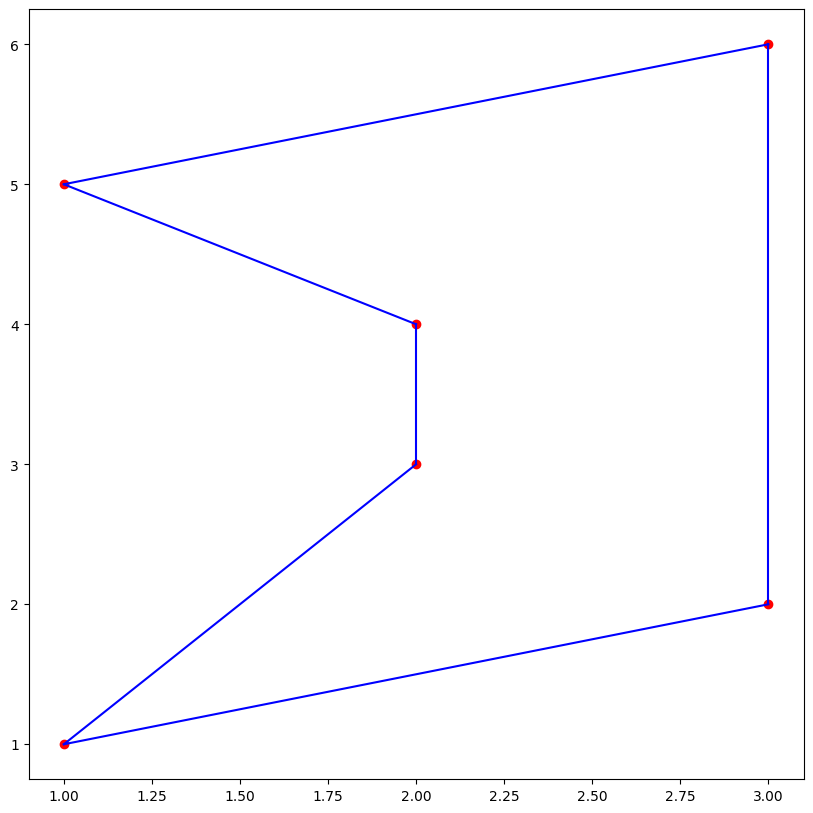

In [35]:
# List of coordinates
coordinates = np.array([[1, 1], [2, 3], [3, 2], [2, 4], [1, 5], [3, 6]])   # 6 nodes

tsp_model = QTSP(coordinates=coordinates, time=30, log=False)

tsp_model(token=token)

We can now simply create a class instance, and call it to run the TSP optimization, and extract the result.

## Final Thoughts

In this notebook, we went through a simple implementation of the Travelling Salesman Problem by formulating a Constrained Quadratic Model (CQM). This implementation can be further improved by defining the constraints more efficiently. Currently, the single visit constraint requires $2N$ constraints to implement, and the subtour elimination constraint requires $2^N - N - 2$ constraints to implement. This puts the overall number of constraints at $2^N + N -1$.



In [36]:
import ipywidgets as widgets
from IPython.display import display

def number_constraints(N: int) -> int:
    """
    Returns the number of constraints for a QUBO formulation of the
    Travelling Salesman Problem with N cities.
    """
    return 2**N - N - 2, 2*N

# Define the interactive widget function
def interactive_number_constraints():
    N_widget = widgets.IntSlider(
        value=5,
        min=2,
        max=15,
        step=1,
        description='Number of Cities (N):',
        style={'description_width': 'initial'}
    )

    svc_widget = widgets.Label()
    sec_widget = widgets.Label()
    result_widget = widgets.Label()

    def update_result(change):
        N = N_widget.value
        subtour_elimination_constraint, single_visit_constraint = number_constraints(N)
        constraints = single_visit_constraint + subtour_elimination_constraint
        svc_widget.value = f"Number of Constraints to implement the single node visit constraint: {single_visit_constraint}"
        sec_widget.value = f"Number of Constraints to implement the subtour elimination constraint: {subtour_elimination_constraint}"
        result_widget.value = f"Total number of Constraints: {constraints}"

    N_widget.observe(update_result, 'value')

    update_result(None)  # Initial update of the result widget

    # Display the widgets
    display(N_widget, svc_widget)
    display(sec_widget)
    display(result_widget)

# Call the interactive widget function to show it in the Jupyter Notebook
interactive_number_constraints()

IntSlider(value=5, description='Number of Cities (N):', max=15, min=2, style=SliderStyle(description_width='in…

Label(value='Number of Constraints to implement the single node visit constraint: 10')

Label(value='Number of Constraints to implement the subtour elimination constraint: 25')

Label(value='Total number of Constraints: 35')

The key focus in these implementations is to have as few binary variables, and constraints as possible, which will directly reduce the cost of mapping the model to D-Wave's QPU.

In the next notebook, we will do exactly that, and improve this rather inelegant implementation to be more efficient.

<br>

<p>© 2024 Amirali Malekani Nezhad, all rights reserved.</p>